In [1]:
import pandas as pd
import numpy as np
from numpy import log
from matplotlib import pyplot as plt 
from scipy.integrate import odeint  # 微分用

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys

# 確保項目根目錄在模組路徑中
project_root = os.path.abspath("COVID-19-TIME-SERIES-PREDICT")  # 替換為你的根目錄路徑
if project_root not in sys.path:
    sys.path.append(project_root)

# 導入自編模組
from utils.common_tools import *

# pandas跟NUMPY設定
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(precision=2, suppress=True)

In [3]:
data = read_covid_data()  # -> pd.DataFrame
data.head()

['AFG' 'OWID_AFR' 'ALB' 'DZA' 'AND' 'AGO' 'AIA' 'ATG' 'ARG' 'ARM' 'ABW'
 'OWID_ASI' 'AUS' 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ'
 'BEN' 'BMU' 'BTN' 'BOL' 'BES' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA'
 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF' 'TCD' 'CHL' 'CHN' 'COL' 'COM'
 'COG' 'COK' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI'
 'DMA' 'DOM' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'OWID_EUR'
 'OWID_EUN' 'FRO' 'FLK' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO' 'DEU'
 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GTM' 'GGY' 'GIN' 'GNB' 'GUY' 'HTI'
 'OWID_HIC' 'HND' 'HKG' 'HUN' 'ISL' 'IND' 'IDN' 'OWID_INT' 'IRN' 'IRQ'
 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JEY' 'JOR' 'KAZ' 'KEN' 'KIR'
 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU'
 'OWID_LIC' 'OWID_LMC' 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT'
 'MHL' 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MCO' 'MNG' 'MNE' 'MSR' 'MAR' 'MOZ'
 'MMR' 'NAM' 'NRU' 'NPL' 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'NIU'
 'OWI

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.00,5.00,NaN,NaN,NaN,NaN,...,NaN,NaN,37.75,0.50,64.83,0.51,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,37.75,0.50,64.83,0.51,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,37.75,0.50,64.83,0.51,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,37.75,0.50,64.83,0.51,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,37.75,0.50,64.83,0.51,NaN,NaN,NaN,NaN


In [4]:
data = extract_SIR_target_data(data)
data.head()

,date,total_cases,new_cases,new_deaths,population
0,2020-02-24,5.00,5.00,NaN,39835428.00
1,2020-02-25,5.00,0.00,NaN,39835428.00
2,2020-02-26,5.00,0.00,NaN,39835428.00
3,2020-02-27,5.00,0.00,NaN,39835428.00
4,2020-02-28,5.00,0.00,NaN,39835428.00


In [5]:
# Here we've got functions here

def dYdt(Y, t, N, beta, gamma) -> list:
    # 三條函式
    # the t argument in the deriv function is technically not redundant, even though it is not directly used in the function
    '''
    Calculate the changing of the three subgroups.
    A: S, I, R
    t: time
    beta: tesla(average persons interacted) * c(infectious rate)
    gamma: recovery rate (=1/d)
    N: total population, assumed S+I+R = N
    '''
    S, I, R = Y
    dSdt = -(beta)*(I)*(S) / N
    dIdt = (beta)*(I)*(S) / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

'''INITIAL STATUS: A = [N - I0, I0, 0]'''


def log_transform(data: pd.DataFrame, column: str):
    data["log_" + column] = log(data[column] + 0.01)
    return data

def adf_test(data: pd.DataFrame, column: str):
    data.dropna(inplace=True)
    result = adfuller(data[column])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("數據是穩態的")
    else:
        print("數據是非穩態的，需要進行差分")

    # 3. 繪製 ACF 和 PACF 檢查自相關性
    plt.figure(figsize=(8, 4))
    plot_acf(data["new_cases"], lags=30, ax=plt.subplot(121))
    plot_pacf(data["new_cases"], lags=30, ax=plt.subplot(122))
    plt.tight_layout()
    plt.show()

def grid_search_ARIMA(data: pd.DataFrame, column: str):
    best_model = None
    best_order = None
    best_aic = float("inf")

    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    model = ARIMA(data[column], order=(p, d, q))
                    model_fit = model.fit()

                    if model_fit.aic < best_aic:
                        best_model = model_fit
                        best_order = (p, d, q)
                        best_aic = model_fit.aic
                except Exception as e:
                    # 捕捉錯誤，但繼續進行其他組合的測試
                    print(f"Error for order ({p}, {d}, {q}): {e}")
                    continue

    if best_model is not None:
        print("Best Model Summary:")
        print(best_model.summary())
    else:
        print("No suitable model found.")

    return best_order

def rolling_forecast(data: pd.DataFrame, column: str, best_order: tuple):
    # 劃分數據集
    train_size = int(len(data) * 0.8 // 1)  # 使用前 80% 的數據作為訓練集
    train = data.iloc[:train_size]     # 訓練集
    test = data.iloc[train_size:]      # 測試集

    print(f"Train Size: {len(train)}, Test Size: {len(test)}")

    # 初始化滾動預測
    history = [x for x in train[column]]  # 使用訓練集的初始數據
    predictions = []  # 儲存每次的預測結果

    # 滾動預測
    for t in range(len(test)):
        # 構建並擬合 ARIMA 模型
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()

        # 預測下一個時間點
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)

        # 將真實值加入訓練集
        history.append(test[column].iloc[t])

    # 計算各種指標
    mae = mean_absolute_error(test[column], predictions)
    r2 = r2_score(test[column], predictions)
    rmse = np.sqrt(mean_squared_error(test[column], predictions))

    print(f"Mean of Real Data: {np.mean(test[column])}")
    print(f"Median of Real Data: {np.median(test[column])}")
    print(f"Mean Absolute Error: {mae}") # 平均絕對誤差
    print(f"Percentage of MAE: {mae / np.mean(test[column])}") # 平均絕對誤差占比
    print(f"Rolling Forecast RMSE: {rmse}") # RMSE

def check_residuals(data: pd.DataFrame, column: str, best_order: tuple):
    # 檢查殘差的自相關性
    model = ARIMA(data[column], order=best_order)
    model_fit = model.fit()
    residuals = model_fit.resid
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(lb_test)

    # 檢查殘差的正態分佈
    stat, p = normaltest(residuals)
    print(f"Normality Test: Statistic={stat}, p={p}")
    if p > 0.05:
        print("殘差接近正態分佈")
    else:
        print("殘差偏離正態分佈")

def multi_step_forecast(data: pd.DataFrame, column: str, best_order: tuple, forecast_steps: int):
    # 劃分數據集
    train_size = int(len(data) * 0.8 // 1)  # 使用前 80% 的數據作為訓練集
    train = data.iloc[:train_size]     # 訓練集
    test = data.iloc[train_size:]      # 測試集
    
    
    model = ARIMA(data[column], order=best_order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)

    # 比較真實值與預測值
    real_values = test["new_cases"].iloc[:forecast_steps]
    rmse = np.sqrt(mean_squared_error(real_values, forecast))
    print(f"Multi-step Forecast RMSE: {rmse}")

def pipeline(data: pd.DataFrame, column: str, forecast_steps: int):
    data = log_transform(data, column)
    adf_test(data, "log_" + column)
    print("----------------Gird Search ARIMA------------------")
    best_order = grid_search_ARIMA(data, "log_" + column)
    print("----------------Rolling Forecast------------------")
    rolling_forecast(data, "log_" + column, best_order)
    print("----------------Check Residuals------------------")
    check_residuals(data, "log_" + column, best_order)
    print("----------------Multi-step Forecast------------------")
    multi_step_forecast(data, "log_" + column, best_order, forecast_steps)

[[39835423.          5.          0.  ]
 [39835422.23        5.26        0.51]
 [39835421.42        5.53        1.05]
 ...
 [17502277.95   492035.5  21841114.55]
 [17470426.74   475513.48 21889487.78]
 [17439701.94   459492.12 21936233.94]]


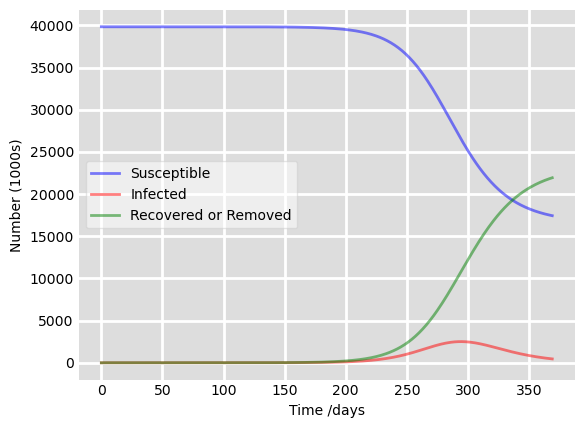

In [6]:
# initialising
gamma = 1/10  # assuming that recovering days are 10 days
cutting_point = 0.5
split_index = int(len(data) * cutting_point)
training_data = data.iloc[:split_index]

population = int(training_data.iloc[0]['population'])
initial_cases = int(training_data.iloc[0]['total_cases'])
S0 = int(population - initial_cases)
I0 = int(initial_cases)
R0 = 0
y0 = (S0, I0, R0)

training_data['date'] = pd.to_datetime(training_data['date'])
t = (training_data['date'] - training_data['date'].iloc[0]).dt.days  # Calculate the numeric time points (days since the first date)

beta = 0.15  # 後用rolling求
S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
# ordinary differential equation integration; odeint的三個arguments: 方程式、Y、Xi
# t is a numeric series, which is necessary for odeint
S, I, R = S_I_R_series.T

print(S_I_R_series)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered or Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# find_best_suiting_beta(y0, t_interval)

In [7]:
def find_best_suiting_beta(y0, t: pd.Series):
    '''Y0為S,I,R之初始狀態；t為尋找beta使用的區間'''
    # 模型指標看mae mae/mean rmse 三個
    # 以前80%的資料，以「用I對比真實累積確診人數」方式，尋找最佳beta
    # 設0.1<=beta<=0.9 
    # mean_absolute_error()
    # 全用global變數
    
    lowest_MAE = 9999999999
    fittest_beta = 0
    for beta in list(map(lambda x: x/10, range(0,10))):
        S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
        I = S_I_R_series.T[2]
        I += y0[1]  # 需要把R加回去 才會是總確診人數
        MAE = mean_absolute_error(I, data['total_cases'].iloc[int(t.iloc[0]):int(t.iloc[-1]+1)])  # 讓I跟相同區間的真實資料(總確診人數)比較

        if MAE < lowest_MAE:
            lowest_MAE = MAE
            fittest_beta = beta

    for beta in list(map(lambda x: x/100, range(int(fittest_beta*100 - 5), int(fittest_beta*100 + 6), 1))):
        S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
        I = S_I_R_series.T[2]
        I += y0[1]  # 需要把R加回去 才會是總確診人數
        MAE = mean_absolute_error(I, data['total_cases'].iloc[int(t.iloc[0]):int(t.iloc[-1]+1)])  # 讓I跟相同區間的真實資料(總確診人數)比較

        if MAE < lowest_MAE:
            lowest_MAE = MAE
            fittest_beta = beta

    for beta in list(map(lambda x: x/1000, range(int(fittest_beta*1000 - 9), int(fittest_beta*1000 + 9), 1))):
        S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
        I = S_I_R_series.T[2]
        I += y0[1]  # 需要把R加回去 才會是總確診人數
        MAE = mean_absolute_error(I, data['total_cases'].iloc[int(t.iloc[0]):int(t.iloc[-1]+1)])  # 讓I跟相同區間的真實資料(總確診人數)比較
        I = pd.Series(I)  # print(I.head()), print(I.tail())

        if MAE < lowest_MAE:
            lowest_MAE = MAE
            fittest_beta = beta

    return fittest_beta, lowest_MAE

# finding the most suiting beta by trying different betas and also comparing the MAEs
find_best_suiting_beta(y0, t) # return (fittest_beta, lowest_MAE)

(0.123, 22511.938564141376)

In [ ]:
# initialising
print(int(1/gamma))

'''
gamma = 1/10  # assuming that recovering days are 10 days
data['date'] = pd.to_datetime(data['date'])
t = (data['date'] - data['date'].iloc[0]).dt.days
t_interval = t.iloc[0:0]
t_interval
len(data)'''

使用  Our world in Data 上的 COVID-19 資料集*，目標預測每日新確診人數  (new_cases)
使用 Rolling Window 方式進行資料切分，以前 28  天預測未來 7 天，每次向前平移 7 天

每天使用模型預測後續疫情走向時，都會用當日以前的歷史資料去為當日建置對應的參數：
1.
每日都會有一個新的SIR Model (即給予)，傳統SIR Model從D0~Dn的beta都是固定的
我們用過去28日的歷史資料算出一個最佳的beta，將當日的S,I,R與算出的beta代入，去預測未來七天的S,I,R

2.建置一個每日beta值都會浮動的SIR模型，去讓從t0開始的模型更貼近真實疫情的走向，
t0~t27日子都會有一個對應的beta值(傳染率)，t28~34則是：預測完t28 -> 將t28預測資料代入計算t28的beta -> 預測t29...

我們先以方法1為準，由於訓練資料缺少Recovered/Removed的資料欄，故假設染病後10天復原/死亡

In [ ]:
# 方法1，得到依資料滾動的beta，每個beta都是用過去28天資料去算出的最佳解（至小數第三位）

# initialising
gamma = 1/10  # assuming that recovering days are 10 days
data['date'] = pd.to_datetime(data['date'])
t = (data['date'] - data['date'].iloc[0]).dt.days
rolling_screen_range = 28  # 整個日期區間為28日
new_cases_prediction_array = np.array([])  # 每次計算七天份，全部放進這個ARRAY跟真實的new cases比較

for i in range(rolling_screen_range-1, len(data), 7):  # 假使i為第幾天，從第28天開始每天用前28天資料預測出的最佳beta
    start_day = i - (rolling_screen_range-1)  # i指的是歷史資料區間結束日，start_day才是歷史資料區間開始日，相差27天意味整個日期區間為28日
    if start_day < 0: start_day = 0
    t_interval = t.iloc[start_day:i+1]  # i指的是區間結束日，slicing + 1

    # 算出start_day(t0)的各項參數S,I,R，再用這個去算最貼近過去28天真實資料的beta
    day_cases_before_date_all_recovered = start_day - int(1/gamma)  # Hypo: start_day 10 (即1/gamma) 天前的確診人一定全復原了（簡化模型）
    if day_cases_before_date_all_recovered < 0: day_cases_before_date_all_recovered = 0
    '''若是1/gamma > start_day 的情況，舉例start_day = 2, 1/gamma = 10
    當始與終為(2,29)，假設T0 (即2日)時，第0日感染的人已經復原的比例為： data['total_cases'].iloc[0] * (1/10) * (2-0)，第1日感染的人已經復原的比例為： data['total_cases'].iloc[1] * (1/10) * (2-1)
    故遞迴公式設為： data['total_cases'].iloc[j] * gamma * (start_day-j)'''

    Rt0 = 0
    for j in range(day_cases_before_date_all_recovered, start_day):
        if (j <= day_cases_before_date_all_recovered): Rt0 += data['total_cases'].iloc[j] * gamma * (start_day-j)
        else: Rt0 += (data['total_cases'].iloc[j] - data['total_cases'].iloc[j-1]) * gamma * (start_day-j)  # 第j日感染人數=total case(j) - total_case(j-1)
    Rt0 = int(Rt0)
    It0 = int(data['total_cases'].iloc[start_day] - Rt0)
    St0 = int(population - It0 - Rt0)
    yt0 = (St0, It0, Rt0)
    
    # 用過去28天真實資料算出最好的beta
    fittest_beta, fittest_beta_MAE = find_best_suiting_beta(yt0, t_interval)
    S_I_R_series = odeint(dYdt, yt0, t_interval, args=(population, fittest_beta, gamma))  # 用fittest beta去算的
    S, I, R = S_I_R_series.T
    I += Rt0
    print('\nThis is day: ' + str(i))
    print('使用歷史資料之起始日與結束日（<=28天）：', t_interval.iloc[0], t_interval.iloc[-1])
    print('歷史資料起始日的 (S,I,R)) =', yt0)
    # print('從歷史資料起始日至截止日 該beta算出的TOTAL_CASES: ', I)
    print('fittest_beta:', fittest_beta, '\nfittest_beta_MAE', fittest_beta_MAE)

    # 計算接下來七天的new cases (相當於dIdt)，先算ti時 S,I,R的狀態
    day_cases_before_date_all_recovered = i - int(1/gamma)  # Hypo: i - 10 (即1/gamma) 天前的確診人一定全復原了（簡化模型）
    if day_cases_before_date_all_recovered < 0: day_cases_before_date_all_recovered = 0
    Rti = 0
    for j in range(day_cases_before_date_all_recovered, i):
        if (j <= day_cases_before_date_all_recovered): Rti += data['total_cases'].iloc[j] * gamma * (i-j)
        else: Rti += (data['total_cases'].iloc[j] - data['total_cases'].iloc[j-1]) * gamma * (i-j)  # 第j日感染人數=total case(j) - total_case(j-1)
    Rti = int(Rti)
    Iti = int(data['total_cases'].iloc[i] - Rti)
    Sti = int(population - Iti - Rti)
    yti = (Sti, Iti, Rti)  
    ytk = yti  # 初始狀態

    # 計算接下來七天的new cases (並不相當於dIdt，其為dSdt，亦為dIdt的前項)
    new_cases_prediction_array_7days = []
    for k in range(i, i+7):
        dSdt, dIdt, dRdt = dYdt(ytk, list(range(i, i+7)), population, fittest_beta, gamma)
        new_cases_prediction_array_7days.append(-dSdt)  # -dSdt = (beta)*(I)*(S) / N, 在I S相近時是最大值，通常是遞增項
        ytk = (ytk[0]+dSdt, ytk[1]+dIdt, ytk[2]+dRdt)
    print('接下來七天的確診人數預測：', new_cases_prediction_array_7days)
    new_cases_prediction_array = np.append(new_cases_prediction_array, new_cases_prediction_array_7days)

print('去除第0天到第27天，針對第28天以後的預測為：', new_cases_prediction_array)
    

    

    # fig = plt.figure(facecolor='w')
    # ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    # ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    # ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    # ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    # ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered or Removed')
    # ax.set_xlabel('Time /days')
    # ax.set_ylabel('Number (1000s)')
    # ax.yaxis.set_tick_params(length=0)
    # ax.xaxis.set_tick_params(length=0)
    # legend = ax.legend()
    # legend.get_frame().set_alpha(0.5)
    # for spine in ('top', 'right', 'bottom', 'left'):
    #     ax.spines[spine].set_visible(False)
    # plt.show()
    

    # fittest_beta加入beta list
'''
# finding the most suiting beta by trying different betas and also comparing the MAEs
population = int(training_data.iloc[0]['population'])
initial_cases = int(training_data.iloc[0]['total_cases'])
S0 = int(population - initial_cases)
I0 = int(initial_cases)
R0 = 0
y0 = (S0, I0, R0)

training_data['date'] = pd.to_datetime(training_data['date'])
t = (training_data['date'] - training_data['date'].iloc[0]).dt.days  # Calculate the numeric time points (days since the first date)

beta = 0.15  # 後用rolling求
S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
# ordinary differential equation integration; odeint的三個arguments: 方程式、Y、Xi
# t is a numeric series, which is necessary for odeint
S, I, R = S_I_R_series.T

print(S_I_R_series)'''


This is day: 27
使用歷史資料之起始日與結束日（<=28天）： 0 27
歷史資料起始日的 (S,I,R)) = (39835423, 5, 0)
fittest_beta: 0.132 
fittest_beta_MAE 3.7949343971516947
接下來七天的確診人數預測： [1.8479984227105581, 1.9071340755616621, 1.968162045210182, 2.0311428840732786, 2.0961390821286807, 2.1632151289088712, 2.232437577478581]

This is day: 34
使用歷史資料之起始日與結束日（<=28天）： 7 34
歷史資料起始日的 (S,I,R)) = (39835423, 2, 3)
fittest_beta: 0.258 
fittest_beta_MAE 5.933404889090505
接下來七天的確診人數預測： [15.479955699735422, 17.925770304922313, 20.758017639568948, 24.037752083058255, 27.835673934908083, 32.23365324225546, 37.32649431456502]

This is day: 41
使用歷史資料之起始日與結束日（<=28天）： 14 41
歷史資料起始日的 (S,I,R)) = (39835420, 3, 5)
fittest_beta: 0.308 
fittest_beta_MAE 14.653787530084248
接下來七天的確診人數預測： [41.8876855936379, 50.600174153212315, 61.12479936791104, 73.83845931569819, 89.19643511892826, 107.7486892903337, 130.1595517034561]

This is day: 48
使用歷史資料之起始日與結束日（<=28天）： 21 48
歷史資料起始日的 (S,I,R)) = (39835403, 15, 10)
fittest_beta: 0.258 
fittest_beta_MAE 33.944

"\n# finding the most suiting beta by trying different betas and also comparing the MAEs\npopulation = int(training_data.iloc[0]['population'])\ninitial_cases = int(training_data.iloc[0]['total_cases'])\nS0 = int(population - initial_cases)\nI0 = int(initial_cases)\nR0 = 0\ny0 = (S0, I0, R0)\n\ntraining_data['date'] = pd.to_datetime(training_data['date'])\nt = (training_data['date'] - training_data['date'].iloc[0]).dt.days  # Calculate the numeric time points (days since the first date)\n\nbeta = 0.15  # 後用rolling求\nS_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))\n# ordinary differential equation integration; odeint的三個arguments: 方程式、Y、Xi\n# t is a numeric series, which is necessary for odeint\nS, I, R = S_I_R_series.T\n\nprint(S_I_R_series)"

In [ ]:
# 得到一個依新資料滾動的beta，每個beta都是用過去28天資料去算出的最佳解（至小數第三位）

# initialising
gamma = 1/10  # assuming that recovering days are 10 days
data['date'] = pd.to_datetime(data['date'])
t = (data['date'] - data['date'].iloc[0]).dt.days

for i in range(0, len(data)):  # 假使i為第幾天
    rolling_screen_range = 28  # 整個日期區間為28日
    start_day = i - (rolling_screen_range-1)  # 相差27天意味整個日期區間為28日，i指的是區間結束日，start_day才是區間開始日
    if start_day < 0: start_day = 0
    t_interval = t.iloc[start_day:i+1]  # i指的是區間結束日，slicing + 1

    day_cases_before_date_all_recovered = start_day - int(1/gamma)  # Hypo: start_day 10 (即1/gamma) 天前的確診人一定全復原了（簡化模型）
    if day_cases_before_date_all_recovered < 0: 
        '''
        寫好以下段落 以對應1/gamma > start_day 的情況，舉例start_day = 2, 1/gamma = 10
        當始與終為(2,29)，假設T0 (即2日)時，
        第0日感染的人已經復原的比例為： data['total_cases'].iloc[0] * (1/10) * (2-0)
        第1日感染的人已經復原的比例為： data['total_cases'].iloc[1] * (1/10) * (2-1)
        故遞迴公式設為： data['total_cases'].iloc[j] * gamma * (start_day-j)
        '''
        day_cases_before_date_all_recovered = 0
        Rt0 = 0
        for j in range(day_cases_before_date_all_recovered, start_day):
            if (j <= 0): Rt0 += data['total_cases'].iloc[j] * gamma * (start_day-j)
            else: Rt0 += (data['total_cases'].iloc[j] - data['total_cases'].iloc[j-1]) * gamma * (start_day-j)  # 第j日感染人數=total case(j) - total_case(j-1)
        Rt0 = int(Rt0)
        It0 = int(data['total_cases'].iloc[start_day] - Rt0)
        St0 = int(population - It0 - Rt0)
    else:
        Rt0 = int(data['total_cases'].iloc[day_cases_before_date_all_recovered])
        It0 = int(data['total_cases'].iloc[start_day] - Rt0)
        St0 = int(population - It0 - Rt0)
   
    yt0 = (St0, It0, Rt0)

    S_I_R_series = odeint(dYdt, yt0, t_interval, args=(population, beta, gamma))
    S, I, R = S_I_R_series.T
    S +=
    
    print('This is: ' + str(i))
    print('起始日與結束日：', t_interval.iloc[0], t_interval.iloc[-1])
    print('Yt0 =', yt0)
    print(I)

    # fig = plt.figure(facecolor='w')
    # ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    # ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    # ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    # ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    # ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered or Removed')
    # ax.set_xlabel('Time /days')
    # ax.set_ylabel('Number (1000s)')
    # ax.yaxis.set_tick_params(length=0)
    # ax.xaxis.set_tick_params(length=0)
    # legend = ax.legend()
    # legend.get_frame().set_alpha(0.5)
    # for spine in ('top', 'right', 'bottom', 'left'):
    #     ax.spines[spine].set_visible(False)
    # plt.show()
    

    # fittest_beta加入beta list
'''
# finding the most suiting beta by trying different betas and also comparing the MAEs
population = int(training_data.iloc[0]['population'])
initial_cases = int(training_data.iloc[0]['total_cases'])
S0 = int(population - initial_cases)
I0 = int(initial_cases)
R0 = 0
y0 = (S0, I0, R0)

training_data['date'] = pd.to_datetime(training_data['date'])
t = (training_data['date'] - training_data['date'].iloc[0]).dt.days  # Calculate the numeric time points (days since the first date)

beta = 0.15  # 後用rolling求
S_I_R_series = odeint(dYdt, y0, t, args=(population, beta, gamma))
# ordinary differential equation integration; odeint的三個arguments: 方程式、Y、Xi
# t is a numeric series, which is necessary for odeint
S, I, R = S_I_R_series.T

print(S_I_R_series)'''

In [52]:
region = ["MYS", "ARG", "MEX", "JPN", "CAN", "THA", "VNM", "TWN", "CHN", "SGP"]

In [ ]:
for region in regionss:
    print(f"----------------Region: {region}------------------")
    data = pd.read_csv(r"data\owid-covid-data.csv")
    data = data[data["iso_code"] == region]
    data = data[["date", "new_cases"]]
    pipeline(data, "new_cases", 30)